## Sarsa

Sarsa是On-Policy的算法，Q-Learning是Off-Policy的算法。

Sarsa也是一种时序查分的学习算法，temporal difference learning，不需要等待episode结束再进行学习。

是Model Free的一个算法，也就是说不需要知道完整的环境模型，比如不需要知道环境的状态转移概率，这里就与传统的控制算法区分开来了，传统的控制算法可以拿到环境的模型，直接求最优解。也就是说如何处理环境的不确定性，是强化学习智能体需要从数据中学习出来的。

Sarsa是一种自举(bootstrapping)的算法，也就是说为了准确的估计一个量，是从另一个估计量来生成的。智能体在学习的过程中是不需要太多的先验知识的，大家都是摸石头过河，因为大家都是估计量。

## 算法

1. 初始化学习率$\alpha$
2. 初始化$Q(s, a)$, ($Q(s, a)$表示未来的期望收益)。
3. 初始化状态$S$
4. 基于epsilon greedy策略从Q中选择动作$A(S)$
5. 循环Loop
    - 采取动作$A$, 获得环境即时奖励$R$，并转移到下一个状态$S^{\prime}$
    - 基于epsilon greedy策略选择下一个状态对应的动作$A^{\prime}(S^{\prime})$
    - 更新$Q(s, a) = Q(s, a) + \alpha(R +  \gamma * Q(s^{\prime}, a^{\prime}) - Q(s, a)$)
    - 更新状态和动作$S = S^{\prime}, A = A^{\prime}$

对于一个Sarsa强化学习智能体来说，需要传入的参数有：

1. 环境
2. 智能体学习所需要的超参数，像学习率，折扣因子

需要的方法有:

1. 依据状态选择动作的策略
2. 更新智能体的方法

```python
class Sarsa(object):
    def __init__(self, env, learning_rate, epsilon, discount):
        super(QLearningAgent, self).__init__()
        pass
    
    def get_action(self, state):
        pass
    
    def update_agent(self, state, action, reward, next_state, next_action):
        pass
```

In [1]:
from collections import defaultdict
import random, math
import numpy as np

In [29]:
class Sarsa(object):
    def __init__(self, env, learning_rate, epsilon, discount):
        super(Sarsa, self).__init__()
        self.legal_action = range(env.action_space.n)  # 获取合法的动作
        
        self.epsilon = epsilon
        self.discount = discount
        self.q_table = defaultdict(lambda: defaultdict(lambda: 0))
        self.lr = learning_rate
    
    def get_action(self, state):
        """
        依据状态选择动作, 加入合法动作是为了方便之后用于复杂环境留的接口
        
        基于epsilon贪婪策略选择动作。
        self.epsilon概率选择随机动作，1 - self.epsilon概率选择最好的动作。
        
        """
        possible_actions = self.legal_action
        
        if len(possible_actions) == 0:
            print("return None")
            return None
        
        epsilon = self.epsilon
        
        if np.random.random() > epsilon:
            possible_q_values = [self.q_table[state][action] for action in possible_actions]
            index = np.argmax(possible_q_values)
            
            return possible_actions[index]
        else:
            
            return random.choice(possible_actions)
    
    def update_agent(self, state, action, reward, next_state, next_action):
        """
        Q值更新公式如下:
        Q(s,a) := (1 - lr) * Q(s,a) + lr * (r + gamma * V(s'))
        """
        current_q = self.q_table[state][action]
        
        next_state_possible_actions = self.legal_action
        
        next_q = self.q_table[next_state][next_action]
        # np.max([self.q_table[next_state][next_action] for next_action in next_state_possible_actions])
        
        new_q = (1 - self.lr) * current_q + self.lr * (reward + self.discount * next_q)
        
        self.q_table[state][action] = new_q

## Sarsa用于离散状态空间

In [30]:
import gym
env = gym.make("Taxi-v3")

In [31]:
print("observation_space {}".format(env.observation_space))
print("action_space {}".format(env.action_space))

observation_space Discrete(500)
action_space Discrete(6)


In [38]:
agent = Sarsa(env, learning_rate=0.5, epsilon=0.05,discount=0.99)

In [39]:
def play_and_train(env,agent,t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    a = agent.get_action(s)
    for t in range(t_max):
        
        
        next_s, r, done, _ = env.step(a)
        next_a = agent.get_action(next_s)
        
        agent.update_agent(s, a, r, next_s, next_a)
        
        s = next_s
        a = next_a
        
        total_reward +=r
        if done:break
        
    return total_reward

mean reward 4.7


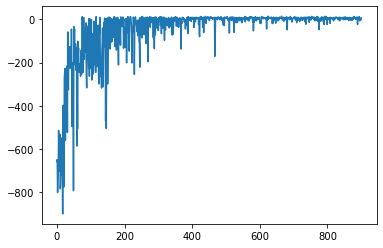

In [40]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

## Sarsa用于连续状态空间

In [42]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000
agent = Sarsa(env, learning_rate=0.1, epsilon=1.0,discount=0.99)

In [43]:
print("observation_space {}".format(env.observation_space))
print("action_space {}".format(env.action_space))

observation_space Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action_space Discrete(3)


In [44]:
pos_space = np.linspace(-1.2, 0.6, 12)
vel_space = np.linspace(-0.07, 0.07, 20)

def get_state(observation):
    pos, vel =  observation
    pos_bin = int(np.digitize(pos, pos_space))
    vel_bin = int(np.digitize(vel, vel_space))

    return (pos_bin, vel_bin)

In [47]:
def play_and_train(env,agent,t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    s = get_state(s)
    a = agent.get_action(s)
    for t in range(t_max):
        
        
        next_s, r, done, _ = env.step(a)
        next_s = get_state(next_s)
        
        next_a = agent.get_action(next_s)
        
        agent.update_agent(s, a, r, next_s, next_a)
        
        s = next_s
        
        a = next_a
        
        total_reward +=r
        if done:break
        
    return total_reward

In [48]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
n_games = 50000
avg_rewards = []
total_rewards = np.zeros(n_games)
for i in range(n_games):
    score = play_and_train(env, agent)
    total_rewards[i] = score
    
    agent.epsilon = agent.epsilon - 2/n_games if agent.epsilon > 0.01 else 0.01
    if i % 100 ==0:
        print('episode ', i, 'score ', score, 'epsilon %.3f' % agent.epsilon)

episode  0 score  -1000.0 epsilon 1.000
episode  100 score  -1000.0 epsilon 0.996
episode  200 score  -1000.0 epsilon 0.992
episode  300 score  -1000.0 epsilon 0.988
episode  400 score  -1000.0 epsilon 0.984
episode  500 score  -1000.0 epsilon 0.980
episode  600 score  -1000.0 epsilon 0.976
episode  700 score  -1000.0 epsilon 0.972
episode  800 score  -1000.0 epsilon 0.968
episode  900 score  -1000.0 epsilon 0.964
episode  1000 score  -1000.0 epsilon 0.960
episode  1100 score  -1000.0 epsilon 0.956
episode  1200 score  -1000.0 epsilon 0.952
episode  1300 score  -1000.0 epsilon 0.948
episode  1400 score  -1000.0 epsilon 0.944
episode  1500 score  -926.0 epsilon 0.940
episode  1600 score  -1000.0 epsilon 0.936
episode  1700 score  -1000.0 epsilon 0.932
episode  1800 score  -736.0 epsilon 0.928
episode  1900 score  -1000.0 epsilon 0.924
episode  2000 score  -1000.0 epsilon 0.920
episode  2100 score  -1000.0 epsilon 0.916
episode  2200 score  -1000.0 epsilon 0.912
episode  2300 score  -100

episode  19200 score  -183.0 epsilon 0.232
episode  19300 score  -160.0 epsilon 0.228
episode  19400 score  -345.0 epsilon 0.224
episode  19500 score  -200.0 epsilon 0.220
episode  19600 score  -150.0 epsilon 0.216
episode  19700 score  -203.0 epsilon 0.212
episode  19800 score  -210.0 epsilon 0.208
episode  19900 score  -256.0 epsilon 0.204
episode  20000 score  -223.0 epsilon 0.200
episode  20100 score  -183.0 epsilon 0.196
episode  20200 score  -274.0 epsilon 0.192
episode  20300 score  -161.0 epsilon 0.188
episode  20400 score  -169.0 epsilon 0.184
episode  20500 score  -194.0 epsilon 0.180
episode  20600 score  -162.0 epsilon 0.176
episode  20700 score  -154.0 epsilon 0.172
episode  20800 score  -157.0 epsilon 0.168
episode  20900 score  -173.0 epsilon 0.164
episode  21000 score  -278.0 epsilon 0.160
episode  21100 score  -189.0 epsilon 0.156
episode  21200 score  -167.0 epsilon 0.152
episode  21300 score  -158.0 epsilon 0.148
episode  21400 score  -161.0 epsilon 0.144
episode  21

episode  38300 score  -147.0 epsilon 0.010
episode  38400 score  -152.0 epsilon 0.010
episode  38500 score  -161.0 epsilon 0.010
episode  38600 score  -111.0 epsilon 0.010
episode  38700 score  -146.0 epsilon 0.010
episode  38800 score  -145.0 epsilon 0.010
episode  38900 score  -150.0 epsilon 0.010
episode  39000 score  -152.0 epsilon 0.010
episode  39100 score  -150.0 epsilon 0.010
episode  39200 score  -146.0 epsilon 0.010
episode  39300 score  -153.0 epsilon 0.010
episode  39400 score  -145.0 epsilon 0.010
episode  39500 score  -144.0 epsilon 0.010
episode  39600 score  -158.0 epsilon 0.010
episode  39700 score  -112.0 epsilon 0.010
episode  39800 score  -114.0 epsilon 0.010
episode  39900 score  -149.0 epsilon 0.010
episode  40000 score  -150.0 epsilon 0.010
episode  40100 score  -159.0 epsilon 0.010
episode  40200 score  -142.0 epsilon 0.010
episode  40300 score  -143.0 epsilon 0.010
episode  40400 score  -155.0 epsilon 0.010
episode  40500 score  -154.0 epsilon 0.010
episode  40

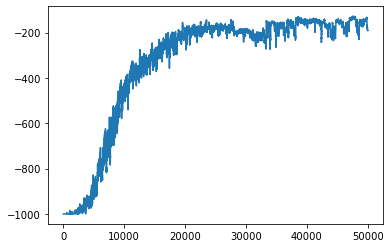

In [49]:
mean_rewards = np.zeros(n_games)
for t in range(n_games):
    mean_rewards[t] = np.mean(total_rewards[max(0, t-50):(t+1)])
plt.plot(mean_rewards)